In [77]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();
plt.rcParams.update({'font.size':16})

import copy
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import sympy
x_sym = sympy.symbols('x_sym')
# https://stackoverflow.com/questions/67450349/how-to-show-a-sympy-equation-in-matplotlib
from sympy.printing import latex
# sympy.init_printing()

import scipy.optimize

import numpy as np
import collocation

<Figure size 432x288 with 0 Axes>

In [78]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [79]:
# np.random.seed(3)
np.random.seed(9)

In [80]:
# X = np.linspace(0, 1, 30)
X = np.linspace(-0.2, 1.2, 100)
X_p = np.linspace(-0.2, 1.2, 30)

y_func = lambda x: x * np.sin(x*4)

y = y_func(X)
y_p = y_func(X_p)

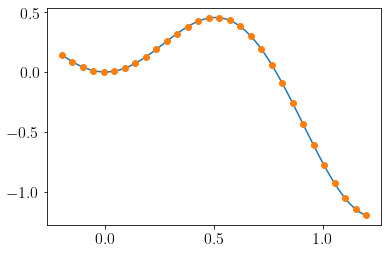

In [81]:
plt.plot(X, y)
plt.plot(X_p, y_p, 'o')

In [82]:
# iy = IUS(X, y)
iy = IUS(X_p, y_p)

In [83]:
collocation_points = {0:[0, 0.5, 1], 1:[0, 1]}
# collocation_points = {0:[0, 1], 1:[0, 1], 2:[1]}
rhs_true = {d:[iy.derivative(d)(v) for v in collocation_points[d]] for d in collocation_points.keys()}
ansatz = sum([x_sym**p for p in range(5)])

In [84]:
ansatz

x_sym**4 + x_sym**3 + x_sym**2 + x_sym + 1

In [85]:
collocation_points

{0: [0, 0.5, 1], 1: [0, 1]}

In [86]:
rhs_true

{0: [array(7.75099158e-07), array(0.45464552), array(-0.75680284)],
 1: [array(0.00020077), array(-3.37135017)]}

In [87]:
cm = collocation.CollocationModel(collocation_points, rhs_true, ansatz)

In [88]:
cm.coeffs

array([ 7.75099158e-07,  2.00766088e-04,  7.68618082e+00, -1.50288282e+01,
        6.58564302e+00])

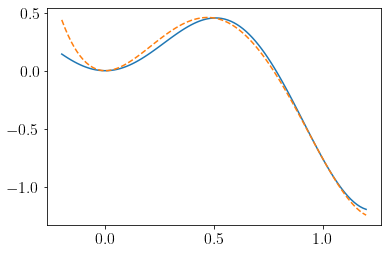

In [89]:
plt.plot(X, y)
plt.plot(X, cm.predict(X), ls='--')

In [90]:
y_func(0)

0.0

In [91]:
cm.predict(np.array([0]))

array([7.75099158e-07])

In [92]:
y_func(1)

-0.7568024953079283

In [93]:
cm.predict(np.array([1]))

array([-0.75680284])

In [94]:
np.abs(y_func(1)-cm.predict(np.array([1])))

array([3.4565159e-07])

In [95]:
y_func(0.5)

0.45464871341284085

In [96]:
cm.predict(np.array([0.5]))

array([0.45464552])

In [97]:
np.abs(y_func(0.5)-cm.predict(np.array([0.5])))

array([3.18970679e-06])

In [98]:
cm.information_matrix

array([[1.    , 0.    , 0.    , 0.    , 0.    ],
       [1.    , 0.5   , 0.25  , 0.125 , 0.0625],
       [1.    , 1.    , 1.    , 1.    , 1.    ],
       [0.    , 1.    , 0.    , 0.    , 0.    ],
       [0.    , 1.    , 2.    , 3.    , 4.    ]])

In [99]:
# lets vary the mid-collocation point, and the derivatives at the ends

In [100]:
rhs_true

{0: [array(7.75099158e-07), array(0.45464552), array(-0.75680284)],
 1: [array(0.00020077), array(-3.37135017)]}

In [101]:
rhs_stars = []
n_samples = 10
for n in range(n_samples):
    rhs_star = copy.deepcopy(rhs_true)
    rhs_star[0][0] += np.random.normal(0, 0.1)
    rhs_star[0][1] += np.random.normal(0, 0.1)
    rhs_star[0][2] += np.random.normal(0, 0.1)
    rhs_star[0][1] += np.random.normal(0, 0.1)
    rhs_star[1][1] += np.random.normal(0, 0.1)
    rhs_stars.append(rhs_star)

In [102]:
yhats = []
for n in range(n_samples):
    cm_ = collocation.CollocationModel(collocation_points, rhs_stars[n], ansatz)
    yhat_ = cm_.predict(X)
    yhats.append(yhat_)
yhats = np.array(yhats)

In [103]:
# standard least squares

In [104]:
def f_(x, a0, a1, a2, a3, a4):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

In [105]:
mask = (X >= 0) & (X <= 1)
popt, pcov = scipy.optimize.curve_fit(f_, X[mask], y[mask])

In [106]:
popt

array([  0.03275448,  -0.94817829,  10.72411231, -18.00244387,
         7.41707504])

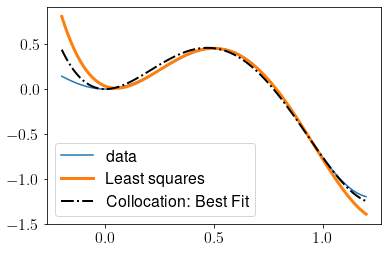

In [107]:
plt.plot(X, y, label='data')
plt.plot(X, f_(X, *popt), label='Least squares', lw=3)
plt.plot(X, cm.predict(X), '-.', lw=2, c='k', label='Collocation: Best Fit')
plt.legend()

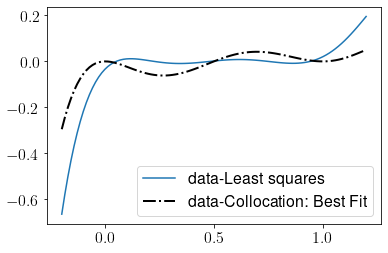

In [108]:
plt.plot(X, y-f_(X, *popt), label='data-Least squares')
plt.plot(X, y-cm.predict(X), '-.', lw=2, c='k', label='data-Collocation: Best Fit')
plt.legend()

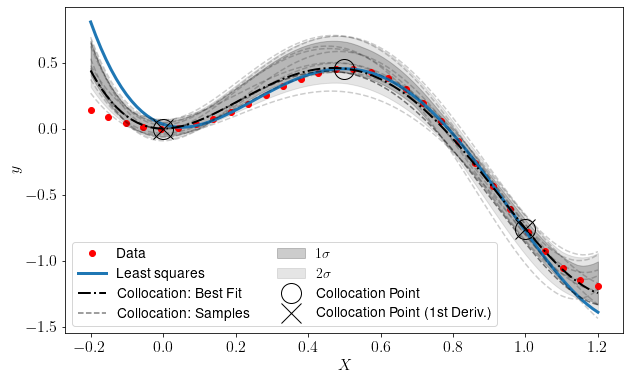

In [110]:
plt.figure(figsize=(10, 6))
plt.plot(X_p, y_p, 'o', c='r', label='Data')


plt.plot(X, f_(X, *popt), label='Least squares', lw=3)

plt.plot(X, cm.predict(X), '-.', lw=2, c='k', label='Collocation: Best Fit')

plt.plot(X, yhats[0], ls='--', c='k', alpha=0.5, label='Collocation: Samples');
plt.plot(X, yhats[1:].T, ls='--', c='k', alpha=0.2);
plt.fill_between(X, y1=np.percentile(yhats, 16, 0), y2=np.percentile(yhats, 84, 0), alpha=0.2, color='k', label=r'$1\sigma$')
plt.fill_between(X, y1=np.percentile(yhats, 5, 0), y2=np.percentile(yhats, 95, 0), alpha=0.1, color='k', label=r'$2\sigma$')
plt.xlabel(r"$X$")
plt.ylabel(r'$y$')
# plt.grid()

# plt.text(0.721, yhats.max()-0.15, f'$y(x) = {latex(ansatz.subs({"x_sym":"x"}))}$',
#          bbox=dict(boxstyle="round", ec='k', fc='white'));


for d in collocation_points:
    for i, v in enumerate(collocation_points[d]):
        if d == 0:
            plt.plot(v, cm.predict(np.array([v])), 'o', zorder=10, c='k', mfc='none', markersize=20, label='Collocation Point' if i == 0 else None)
        if d == 1:
            plt.plot(v, cm.predict(np.array([v])), 'x', zorder=10, c='k', mfc='none', markersize=20, mew=1, label='Collocation Point (1st Deriv.)' if i == 0 else None)
        if d == 2:
            plt.plot(v, cm.predict(np.array([v])), '+', zorder=10, c='k', mfc='none', markersize=20, mew=1, label='Collocation Point (2nd Deriv.)' if i == 0 else None)
        
plt.legend(loc='lower left', ncol=2, fontsize=14)
# plt.savefig("/Users/sebastian.khan/personal/git/stk/phenprob-paper/paper/figs/collocation_example.pdf")